In [1]:
import pandas as pd
from pybliometrics.scopus import ScopusSearch, AbstractRetrieval, AuthorRetrieval, ContentAffiliationRetrieval
import networkx as nx

nodes=pd.DataFrame()
edges=[]
gen={}
htc = "10.1257/aer.20140850"

shleifer1 = "10.1257/jel.46.2.285" #economicconsequences
shleifer2 = "10.1257/jep.28.3.109" #informalityanddevelopment
shleifer3 = "10.1016/j.jfineco.2018.04.007" #extrapolationandbubbles
ab = AbstractRetrieval(shleifer1, view="FULL")


We begin by adding all of the papers which Paper 0 cites.

In [2]:
nodes=pd.DataFrame()
nodes = nodes.append({"id":"", "title": ab.title, "sourcetitle": ab.sourcetitle_abbreviation, "publicationyear": ab.coverDate[0:4], "eid": ab.eid, "gen": '0' }, ignore_index=True)
ref_df = pd.DataFrame(ab.references)
ref_df["eid"] = '2-s2.0-' + ref_df['id']
ref_df['gen'] = '-1'

ref_df2 = pd.concat([ref_df['eid'], ref_df['id'], ref_df['publicationyear'], ref_df['sourcetitle'], ref_df['title'], ref_df['gen']], axis=1, keys=['eid', 'id', 'publicationyear', 'sourcetitle', 'title', 'gen'], sort=True)
#ref_df2 = ref_df2.drop(18)
nodes = nodes.append(ref_df2, ignore_index = True, sort=True)

for row in ref_df2.itertuples():
    edges.append((row.eid, ab.eid))

len(nodes)

175

Then, we add all of the papers which cite Paper 0.

In [3]:
s = ScopusSearch(ab.eid) 
for x in s.results:
    if(x.eid not in list(nodes['eid'])):
        nodes = nodes.append({"id":"", "title": x.title, "sourcetitle": "", "publicationyear": x.coverDate[0:4], "eid": x.eid, "gen": '1' }, ignore_index=True)
    edges.append((ab.eid, x.eid))

print(len(nodes)) 

1399


Then, we add all of the papers which the papers cited by paper 0 have themselves cited. (Generation -2)

In [4]:
for y in ab.references:
    refs = AbstractRetrieval(y.id, view="FULL")
    if(refs.references != None):
        ref_df = pd.DataFrame(refs.references)
        ref_df["eid"] = '2-s2.0-' + ref_df['id']
        ref_df['gen'] = '-2'
        ref_df2 = pd.concat([ref_df['eid'], ref_df['id'], ref_df['publicationyear'], ref_df['sourcetitle'], ref_df['title'], ref_df['gen']], axis=1, keys=['eid', 'id', 'publicationyear', 'sourcetitle', 'title', 'gen'])
        
        for row in ref_df2.itertuples():
            if(row.id == '0000131597'):
                print("here")
            edges.append((row.eid, '2-s2.0-' + y.id))
            if(row.id == '0000131597'):
                print((row.eid, '2-s2.0-' + y.id))
                print("now here")
            if(row.eid not in list(nodes['eid'])):
                nodes = nodes.append({"id":row.id, "title": row.title, "sourcetitle": row.sourcetitle, "publicationyear": row.publicationyear, "eid": row.eid, "gen": '-2' }, ignore_index=True)
            
len(nodes)

5172

And the papers which Generation 1 papers cite.

In [5]:
for x in s.results:
    s = AbstractRetrieval(x.eid, view="FULL")
    if(s.references != None):
        ref_df = pd.DataFrame(s.references)
        ref_df['eid'] = '2-s2.0-'+ ref_df['id']
        ref_df['gen'] = '9'
        ref_df2 = pd.concat([ref_df['eid'], ref_df['id'], ref_df['publicationyear'], ref_df['sourcetitle'], ref_df['title'], ref_df['gen']], axis=1, keys=['eid', 'id', 'publicationyear', 'sourcetitle', 'title', 'gen'])
        
        for row in ref_df2.itertuples():
            if(row.eid not in list(nodes['eid'])):
                nodes = nodes.append({"id": row.id, "title": row.title, "sourcetitle": row.sourcetitle, "publicationyear": row.publicationyear, "eid": row.eid, "gen": row.gen }, ignore_index=True)
            edges.append((row.eid, x.eid))
    
print(len(nodes))

73226


We also add the papers which have cited the papers that Paper 0 cites.

In [6]:
import time
import random

then = time.time()
for y in ab.references:
    search = ScopusSearch(y.id, verbose=True)
    for x in search.results:
        edges.append(('2-s2.0-' + y.id, x.eid))
        if(x.eid not in list(nodes['eid'])):
            nodes = nodes.append({"id":"", "title": x.title, "sourcetitle": "", "publicationyear": x.coverDate[0:4], "eid": x.eid, "gen": "9"}, ignore_index = True)

now = time.time()
print("It took: ", now-then, " seconds")


It took:  2140.274173259735  seconds


In [7]:
s = ScopusSearch(ab.eid) 
        
for x in s.results:
    s = ScopusSearch(x.eid, verbose = True)
    if (s.results != None):
        for z in s.results:
            edges.append((x.eid, z.eid))
            if(z.eid not in list(nodes['eid'])):
                nodes = nodes.append({"id":"", "title": z.title, "sourcetitle": "", "publicationyear": z.coverDate[0:4], "eid": z.eid, "gen": "2"}, ignore_index = True)
            
len(nodes)

146317

In [8]:
import matplotlib.pyplot as plt # Version 3.0.3
import numpy as np

node_names = nodes['eid']   
gen = nodes.set_index('eid')['gen'].to_dict()

G = nx.DiGraph()
G.add_nodes_from(node_names)
G.add_edges_from(edges)
nx.set_node_attributes(G, gen, "gen")



pos=nx.circular_layout(G) # positions for all nodes

cols = [v for v in gen.values()]
cols = ["red" if x=='0' else x for x in cols]
cols = ["darkorange" if x=='-1' else x for x in cols]
cols = ["aqua" if x=='1' else x for x in cols]
cols = ["cornflowerblue" if x=='-2' else x for x in cols]
cols = ["blue" if x=="" else x for x in cols]
    


In [9]:
nodes.to_excel("nodes_Example1.xlsx")

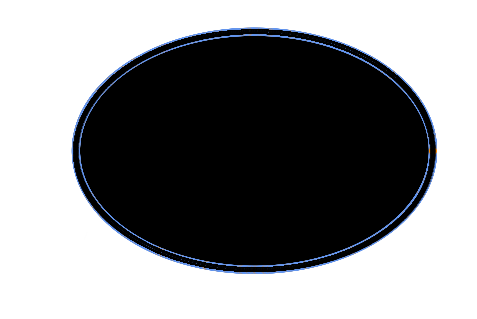

In [17]:
selected_nodes = [n for n,v in G.nodes(data=True) if v['gen'] == '0' or v['gen'] == '-1' or v['gen'] == '-2']  
G2 = G.subgraph(selected_nodes)
pos=nx.circular_layout(G2) # positions for all nodes
# pos = {key:value for key,value in pos.items() if key in selected_nodes}
labels=dict((n,d['gen']) for n,d in G2.nodes(data=True))

cols = [v for v in labels.values()]
cols = ["red" if x=='0' else x for x in cols]
cols = ["darkorange" if x=='-1' else x for x in cols]
# cols = ["aqua" if x=='1' else x for x in cols]
cols = ["cornflowerblue" if x=='-2' else x for x in cols]
cols = ["blue" if x=="" else x for x in cols]

nx.draw_circular(G2, node_size = 50, node_color = cols) #, node_size = sizes)
nx.draw_networkx_labels(G2,pos, labels, font_size=7)
plt.savefig('network1-1.pdf', bbox_inches='tight', figsize=(50, 50))




In [18]:
list(nx.isolates(G2)) 

[]

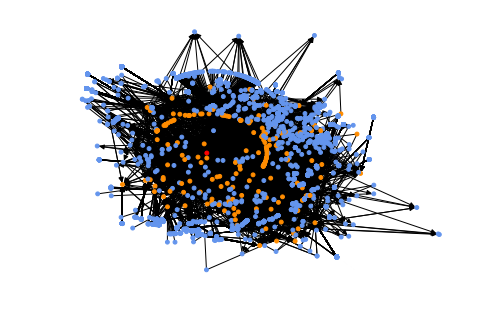

In [19]:
pos=nx.kamada_kawai_layout(G2) # positions for all nodes

nx.draw_kamada_kawai(G2, node_size = 15, node_color=cols)
#nx.draw_networkx_labels(G2,pos, labels, font_size=7)

plt.savefig('network-Example1.pdf', bbox_inches='tight', figsize=(50, 50))



Compare: Katz, in-degree, PageRank, eigenvector centrality

In [20]:
all_indegree = nx.in_degree_centrality(G)
all_katz = nx.katz_centrality(G)
all_eigens = nx.eigenvector_centrality(G)
all_pagerank = nx.pagerank(G)
katz = {key:value for key,value in all_katz.items() if key in selected_nodes}
indegree = {key:value for key,value in all_indegree.items() if key in selected_nodes}
eigens = {key:value for key,value in all_eigens.items() if key in selected_nodes}
pagerank = {key:value for key,value in all_pagerank.items() if key in selected_nodes}

In [21]:
gen1 = [n for n,v in G.nodes(data=True) if v['gen'] == '-1']  
gen1_katz = {key:value for key,value in all_katz.items() if key in gen1}
gen1_indegree = {key:value for key,value in all_indegree.items() if key in gen1}
gen1_eigens = {key:value for key,value in all_eigens.items() if key in gen1}
gen1_pagerank = {key:value for key,value in all_pagerank.items() if key in gen1}

In [22]:
print("Paper 0")
print("Katz: ", katz[ab.eid])
print("Indegree: ", indegree[ab.eid])
print("Eigenvector centrality: ", eigens[ab.eid])
print("PageRank: ", pagerank[ab.eid])

Paper 0
Katz:  0.06589572059971527
Indegree:  0.0011892069220044287
Eigenvector centrality:  0.004405117021254823
PageRank:  0.0001649024592187636


And our discounted eigenvector centralities for the papers in generation -1 are:

In [24]:
new_df = pd.DataFrame()
for i in gen1:
    new_df=new_df.append({"eid": i,
                          "original.katz": gen1_katz[i],
                          "discounted.katz": gen1_katz[i]*0.98**(2019-nodes[nodes['eid'] == i]['publicationyear'].astype(float)).values[0],
                          "original.indegree": gen1_indegree[i],
                          "discounted.indegree": gen1_indegree[i]*0.98**(2019-nodes[nodes['eid'] == i]['publicationyear'].astype(float)).values[0],
                         "original.eigens": gen1_eigens[i],
                         "discounted.eigens": gen1_eigens[i]*0.98**(2019-nodes[nodes['eid'] == i]['publicationyear'].astype(float)).values[0],
                         "original.pagerank": gen1_pagerank[i],
                         "discounted.pagerank": gen1_pagerank[i]*0.98**(2019-nodes[nodes['eid'] == i]['publicationyear'].astype(float)).values[0]}, ignore_index=True)
#     new_df=new_df.append({"eid": i,"discounted": gen1_eigens[i]}, ignore_index=True)
new_df.sort_values("discounted.pagerank", ascending=False)

,discounted.eigens,discounted.indegree,discounted.katz,discounted.pagerank,eid,original.eigens,original.indegree,original.katz,original.pagerank
165,2.826202e-24,0.001665,0.011517,8.679274e-04,2-s2.0-85058279252,5.731794e-24,0.003376,0.023358,0.001760
34,5.643202e-11,0.001525,0.015270,6.663227e-04,2-s2.0-0011088449,8.118134e-11,0.002194,0.021967,0.000959
33,3.892107e-13,0.001424,0.011633,6.368732e-04,2-s2.0-0042261097,5.829929e-13,0.002132,0.017425,0.000954
2,3.961433e-09,0.001050,0.008282,3.835751e-04,2-s2.0-84920688976,5.363659e-09,0.001422,0.011214,0.000519
150,2.120910e-11,0.000945,0.009439,3.656047e-04,2-s2.0-0347667534,3.113342e-11,0.001387,0.013855,0.000537
116,2.150948e-08,0.000699,0.007066,2.596332e-04,2-s2.0-84920615081,2.796990e-08,0.000909,0.009188,0.000338
156,1.084828e-13,0.001039,0.009099,2.398385e-04,2-s2.0-0001026456,1.691949e-13,0.001620,0.014191,0.000374
54,8.605454e-11,0.000587,0.009289,2.245780e-04,2-s2.0-33947191830,1.213195e-10,0.000827,0.013095,0.000317
96,5.072402e-11,0.000500,0.005067,1.718169e-04,2-s2.0-24144484896,6.730520e-11,0.000663,0.006724,0.000228
126,2.047083e-04,0.000416,0.007193,1.417156e-04,2-s2.0-40449141992,2.556517e-04,0.000519,0.008983,0.000177


In [25]:
new_df.to_excel("Example1.xlsx") 

In [26]:
print("PageRank: ", pagerank[ab.eid])
print("Indegree: ", indegree[ab.eid])
print("Katz: ", katz[ab.eid])
print("Eigenvector: ", eigens[ab.eid])

PageRank:  0.0001649024592187636
Indegree:  0.0011892069220044287
Katz:  0.06589572059971527
Eigenvector:  0.004405117021254823


In [250]:
year=int(AbstractRetrieval(ab.eid).coverDate[0:4])
paper0_score_katz = katz[ab.eid]*0.98**(2019-year)
gen1_average_katz = new_df["discounted.katz"].mean()
gen1_average_katz

0.02443215870453407

In [251]:
paper0_score_katz/(paper0_score_katz+gen1_average_katz)

0.8454840884223284

In [43]:
gen1_average_katz+paper0_score_katz

0.1528266002302053

In [27]:
len(nodes)

146317

12% of the total credit flows to the very influential paper in Generation -1, that received ~4000 citations - this is the paper by Hirsch that introduces the H-index.

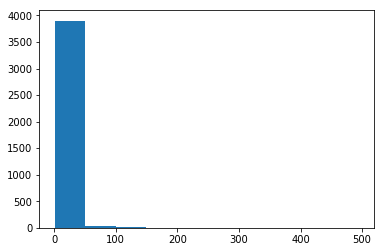

In [31]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G2)

In [37]:
import numpy
def average_citations(G, mynodes):
    degrees = [G.in_degree(n) for n in mynodes]
    print(numpy.mean(degrees))
    
selected_nodes_citation = [n for n,v in G.nodes(data=True) if v['gen'] == '-1']  
average_citations(G, selected_nodes_citation)


30.448275862068964


In [30]:
nx.write_gexf(G2, "example1.gexf")